In [1]:
from definitions import TCAV, Concept

# from captum.concept import TCAV
import torch
import torch.nn as nn
from torchvision.models import resnet18
import numpy as np
import os, glob

import matplotlib.pyplot as plt

from PIL import Image

from scipy.stats import ttest_ind

# ..........torch imports............
import torchvision

from torch.utils.data import IterableDataset, DataLoader
from torchvision import transforms

#.... Captum imports..................
from captum.attr import LayerGradientXActivation, LayerIntegratedGradients

# from captum.concept import TCAV
# from captum.concept import Concept

from captum.concept._utils.data_iterator import dataset_to_dataloader, CustomIterableDataset
from captum.concept._utils.common import concepts_to_str
import cv2

from typing import Any, cast, Dict, List, Set, Tuple, Union, Callable, Optional, TypeVar

from torch.nn import Module
from torch import Tensor

from collections import defaultdict
from typing import Any, cast, Dict, List, Set, Tuple, Union

import numpy as np

from captum.attr import LayerActivation, LayerAttribution, LayerGradientXActivation
from captum._utils.common import _format_tensor_into_tuples, _get_module_from_name
from abc import ABC, abstractmethod
import warnings


In [2]:
# Method to normalize an image to Imagenet mean and standard deviation
def transform(img):

    return transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )(img)

def get_tensor_from_filename(filename):
    img = Image.open(filename).convert("RGB")
    return transform(img)


def load_image_tensors(class_name, root_path='data/tcav/images/imagenet/', transform=True):
    path = os.path.join(root_path, class_name)
    filenames = glob.glob(path + '/*.jpg')

    tensors = []
    for filename in filenames:
        img = Image.open(filename).convert('RGB')
        tensors.append(transform(img) if transform else img)
    
    return tensors

def assemble_concept(name, id, concepts_path="data/tcav/images/concepts/"):
    concept_path = os.path.join(concepts_path, name) + "/"
    dataset = CustomIterableDataset(get_tensor_from_filename, concept_path)
    concept_iter = dataset_to_dataloader(dataset)

    return Concept(id=id, name=name, data_iter=concept_iter)

    

In [3]:
concepts_path = "data/tcav/images/concepts/"

stripes_concept = assemble_concept("striped", 0, concepts_path=concepts_path)
zigzagged_concept = assemble_concept("zigzagged", 1, concepts_path=concepts_path)
dotted_concept = assemble_concept("dotted", 2, concepts_path=concepts_path)


random_0_concept = assemble_concept("random_0", 3, concepts_path=concepts_path)
random_1_concept = assemble_concept("random_1", 4, concepts_path=concepts_path)


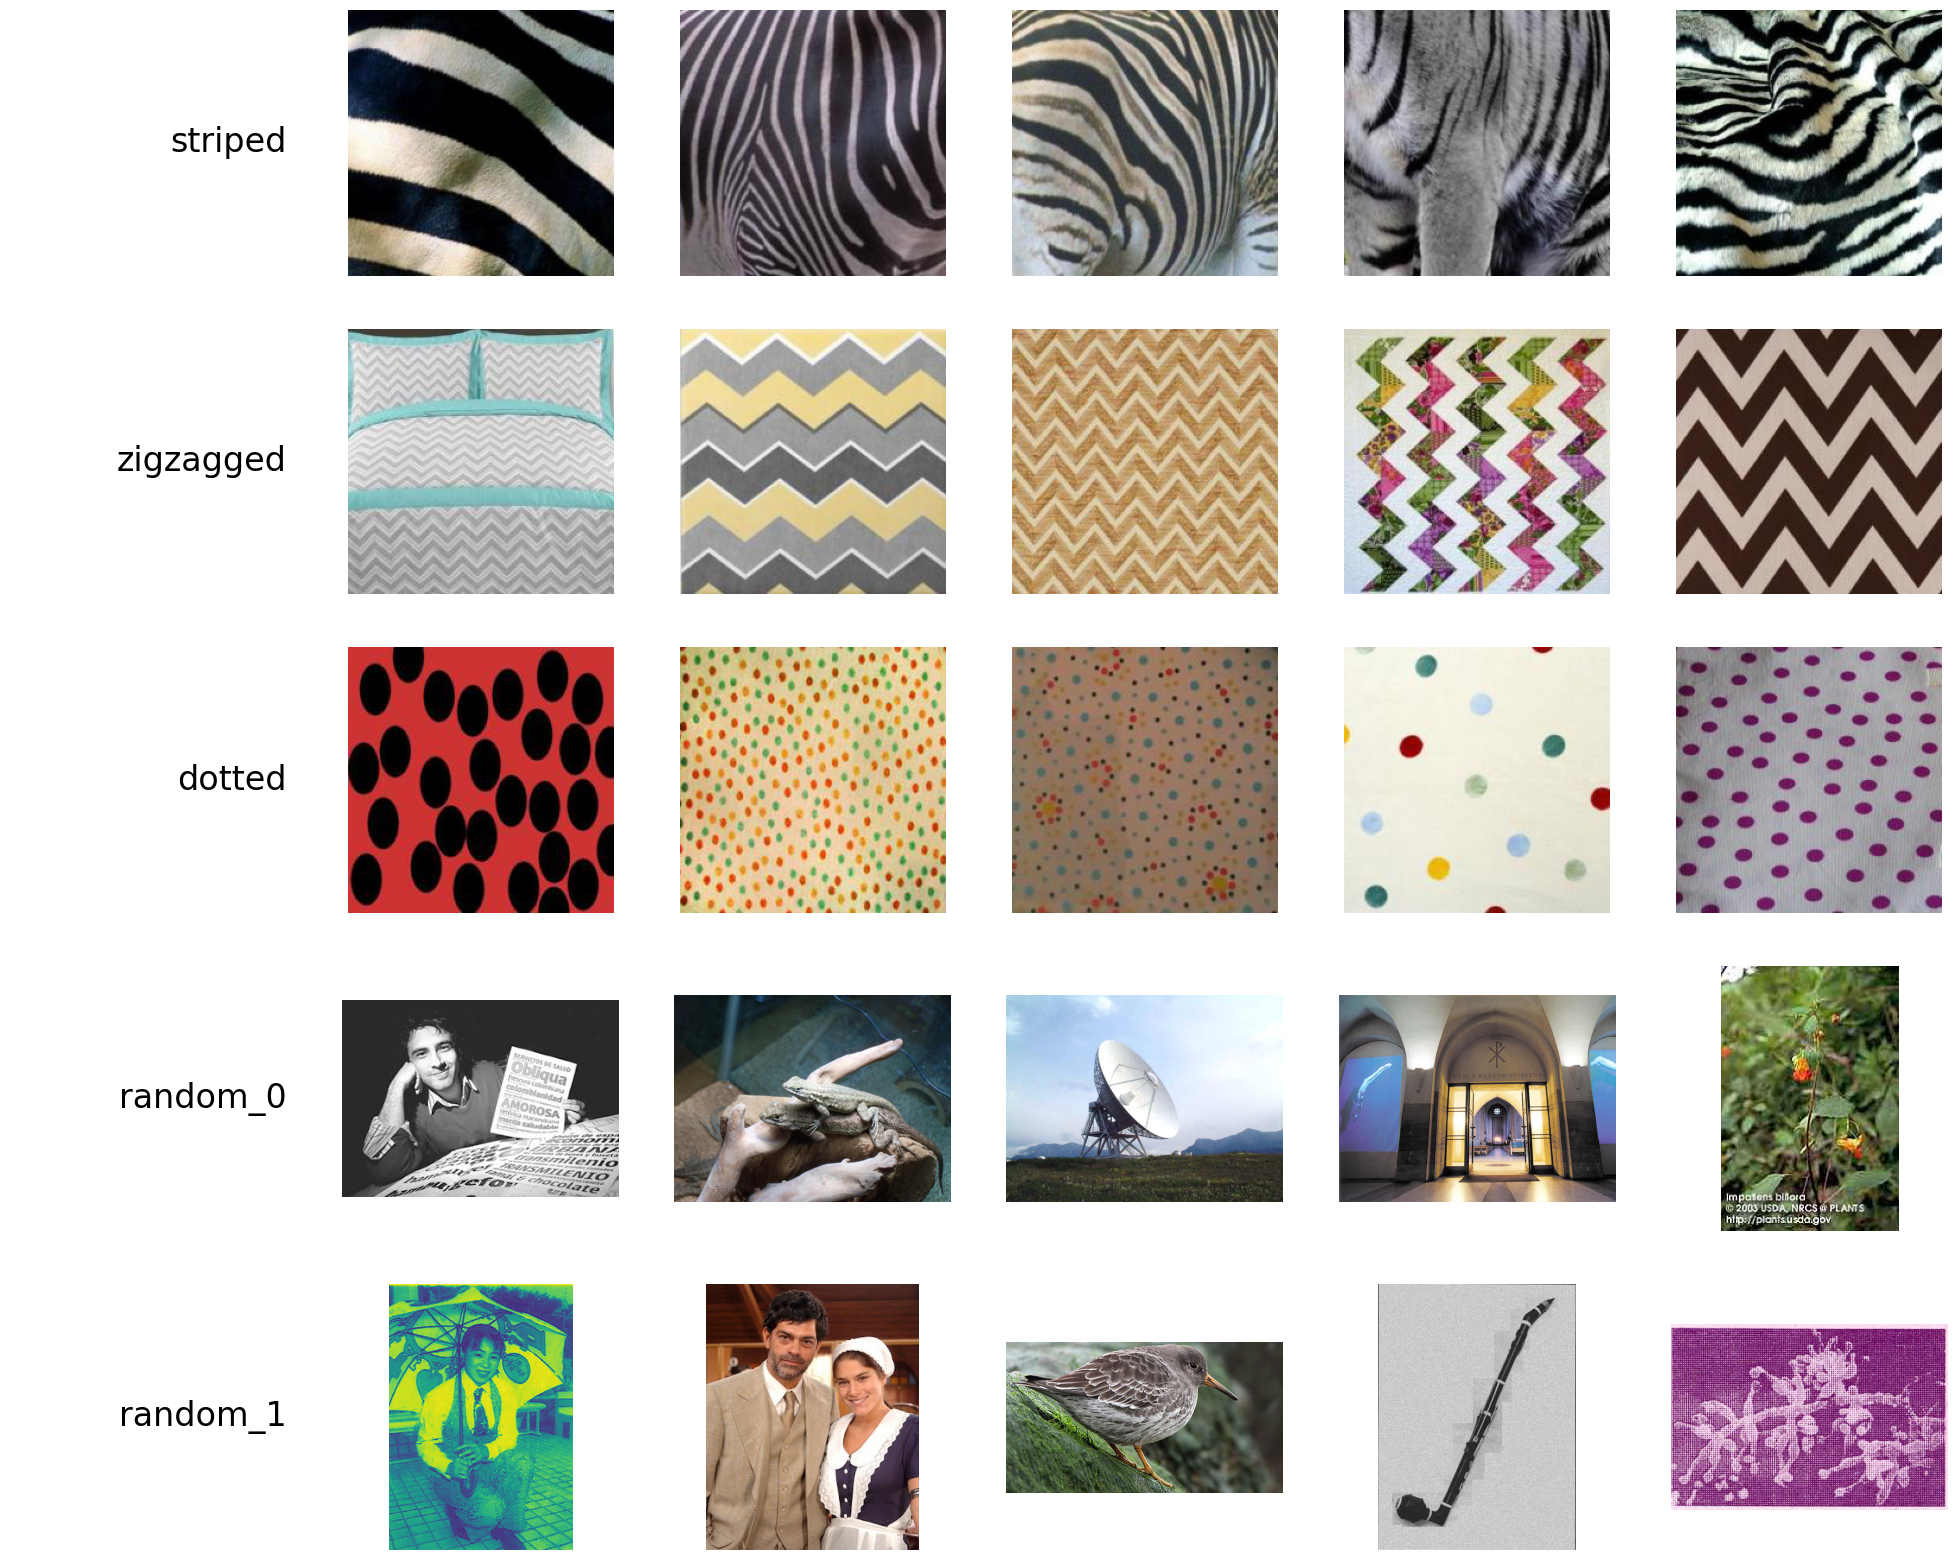

In [4]:
n_figs = 5
n_concepts = 5

fig, axs = plt.subplots(n_concepts, n_figs + 1, figsize = (25, 4 * n_concepts))

for c, concept in enumerate([stripes_concept, zigzagged_concept, dotted_concept, random_0_concept, random_1_concept]):
    concept_path = os.path.join(concepts_path, concept.name) + "/"
    img_files = glob.glob(concept_path + '*')
    for i, img_file in enumerate(img_files[:n_figs + 1]):
        if os.path.isfile(img_file):
            if i == 0:
                axs[c, i].text(1.0, 0.5, str(concept.name), ha='right', va='center', family='sans-serif', size=24)
            else:
                img = plt.imread(img_file)
                axs[c, i].imshow(img)

            axs[c, i].axis('off')

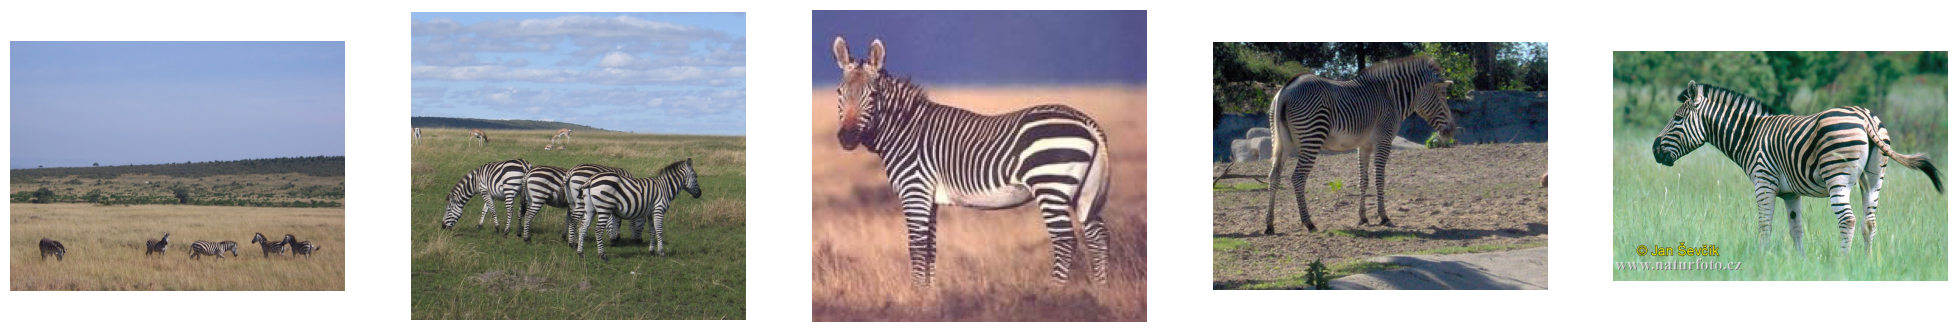

In [5]:
experimental_set_rand = [[stripes_concept, random_0_concept], [stripes_concept, random_1_concept]]
zebra_imgs = load_image_tensors('zebra', transform=False)
fig, axs = plt.subplots(1, 5, figsize = (25, 5))
axs[0].imshow(zebra_imgs[20])
axs[1].imshow(zebra_imgs[21])
axs[2].imshow(zebra_imgs[24])
axs[3].imshow(zebra_imgs[11])
axs[4].imshow(zebra_imgs[10])

axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')
axs[4].axis('off')

plt.show()

In [6]:
model = torchvision.models.vgg16(pretrained=True)
model = model.eval()
model1=model.features
# stripes = Concept(0, "stripes", striped_data_iter)
# random = Concept(1, "random", random_data_iter)
layers=['0','1']


mytcav = TCAV(model=model1,
              layers=layers
#               layer_attr_method = LayerIntegratedGradients(
#                 model, None, multiply_by_inputs=False)
             )
# print(mytcav.layers)
# scores = mytcav.interpret(inputs, [[stripes, random]], target = 0)
model1

/home/ainesh/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ainesh/anaconda3/envs/tf/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/ainesh/anaconda3/envs/tf/lib/python3.9/site-packages/captum/concept/_utils/classifier.py:130: UserWarning: Using default classifier for TCAV which keeps input both train and test datasets in the memory. Consider defining your own classifier that doesn't rely heavily on memory, for large number of concepts, by extending `Classifer` abstra

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
# Load sample images from folder
zebra_tensors = torch.stack([transform(img) for img in zebra_imgs])
experimental_set_rand
# zebra class index
zebra_ind = 340


tcav_scores_w_random = mytcav.interpret(inputs=zebra_tensors,
                                        experimental_sets=experimental_set_rand,
                                        target=zebra_ind,
#                                         n_steps=5,
                                       )

tcav_scores_w_random

/home/ainesh/anaconda3/envs/tf/lib/python3.9/site-packages/captum/_utils/models/linear_model/train.py:350: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1678402323377/work/torch/csrc/utils/tensor_new.cpp:245.)
  bias_values = torch.FloatTensor([sklearn_model.intercept_]).to(  # type: ignore


[2 2]


RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [ ]:
def format_float(f):
    return float('{:.3f}'.format(f) if abs(f) >= 0.0005 else '{:.3e}'.format(f))

def plot_tcav_scores(experimental_sets, tcav_scores):
    fig, ax = plt.subplots(1, len(experimental_sets), figsize = (25, 7))

    barWidth = 1 / (len(experimental_sets[0]) + 1)

    for idx_es, concepts in enumerate(experimental_sets):

        concepts = experimental_sets[idx_es]
        concepts_key = concepts_to_str(concepts)

        pos = [np.arange(len(layers))]
        for i in range(1, len(concepts)):
            pos.append([(x + barWidth) for x in pos[i-1]])
        _ax = (ax[idx_es] if len(experimental_sets) > 1 else ax)
        for i in range(len(concepts)):
            val = [format_float(scores['sign_count'][i]) for layer, scores in tcav_scores[concepts_key].items()]
            _ax.bar(pos[i], val, width=barWidth, edgecolor='white', label=concepts[i].name)

        # Add xticks on the middle of the group bars
        _ax.set_xlabel('Set {}'.format(str(idx_es)), fontweight='bold', fontsize=16)
        _ax.set_xticks([r + 0.3 * barWidth for r in range(len(layers))])
        _ax.set_xticklabels(layers, fontsize=16)

        # Create legend & Show graphic
        _ax.legend(fontsize=16)

    plt.show()

In [ ]:
plot_tcav_scores(experimental_set_rand, tcav_scores_w_random)
experimental_set_zig_dot = [[stripes_concept, zigzagged_concept, dotted_concept]]


In [ ]:
tcav_scores_w_zig_dot = mytcav.interpret(inputs=zebra_tensors,
                                         experimental_sets=experimental_set_zig_dot,
                                         target=zebra_ind,
                                        )

plot_tcav_scores(experimental_set_zig_dot, tcav_scores_w_zig_dot)